In [34]:
from ijcai2022nmmo import CompetitionConfig, scripted, TeamBasedEnv, Team
import nmmo
import numpy as np
import copy
import gym
import matplotlib.pyplot as plt
from gym import spaces 


class MyTrainEnv(gym.Env):
    def __init__(self,env_config:dict):
        self.config = CompetitionConfig()
        self.team_env = TeamBasedEnv(self.config)
        self.env_config = env_config
        #observation_space = [spaces.MultiDiscrete(2*np.ones((129,129),dtype=np.int32))]*8
        self.observation_space = spaces.Tuple(( spaces.Box(low=-np.infty,high=np.infty,shape=(129,129,40),dtype=np.float32),
                                               spaces.Box(low=-np.infty,high=np.infty,shape=(88,),dtype=np.float32) 
                                             ))
        self.action_space = spaces.Box(low=-np.infty,high=np.infty,shape=(80,),dtype=np.float32)
        
    def reset(self):
        self.obs_by_team = self.team_env.reset()
        self.n_tick = 0 
        ##### establish the teams:
        self.teams = []
        self.teams += [MyAwesomeTeam("MyTeam",self.config)]
        team_config = self.env_config["teams"]
        for key, team_num in team_config.items():
            if team_num>0:
                designed_team = getattr(scripted,key)
                self.teams += [designed_team(key+f"-{i}",self.config) for i in range(team_num)] 
        ############################
        
        for team in self.teams:
            team.reset()
        
        # myteam population id = 0
        obs_to_myteam = obs_by_team[0]
        
        new_obs = self.teams[0].update_map(obs_to_myteam)
        return new_obs
        
    def step(self,action):
        actions = {}
        ####### convert the output of the policy into the true action
        new_my_action = sself.teams[0].act(action)
        
        
        actions[0]=new_my_actions
        ############
        
        ####### obtain the actions of other teams
        for team_index in range(1,16):
            other_actions = self.teams[team_index].act(self.obs_by_team[team_index])
            actions[team_index] = other_actions
        self.obs_by_team = self.team_env.step(actions)
        obs_to_myteam = self.obs_by_team[0]
        
        new_my_obs = self.teams[0].update_map(obs_to_myteam)
        
        self.n_tick += 1 
        ######## reward
        reward = 0
        done=False
        info = {}
        
        
        ######## done
        
        return new_my_obs,reward,done,info
        

In [37]:

########################
## Myteam
class MyAwesomeTeam(Team):
    def reset(self):
        # reset some states
        self.global_map = {}
        self.n_tick = 0 
        self.LOCAL_BIAS = 16
        self.global_information={ "hunting_level":10, 
                                  "fishing_level":10,
                                  "kill_npc_level":0,
                                  "kill_npc_num":0,
                                  "kill_opponent_num":0}
        self.last_action_informations= [ [0,0] for i in range(8) ]  # id-level
    
    def obs_normalization(self,agent_layers,agent_vectors,opponents,npcs,terrain):
        MAX_LEVEL = 80
        MAX_HEALTH = MAX_LEVEL
        MAX_FOOD = 80 
        MAX_WATER = 80
        MAX_DAMAGE = 1000
        MAX_HUNTING_LEVEL = 75 
        MAX_FISHING_LEVEL = 75 
        MAX_KILL_NUM = 20
        
        # normalization for the agents
        for agent_index in range(8):
            # level
            agent_vectors[agent_index*11+0] /= MAX_LEVEL
            # health
            agent_vectors[agent_index*11+1] /= MAX_HEALTH
            # food
            agent_vectors[agent_index*11+2] /= MAX_FOOD
            # water 
            agent_vectors[agent_index*11+3] /= MAX_WATER
            # DAMAGE 
            agent_vectors[agent_index*11+4] /= MAX_DAMAGE
            # HUNTING_LEVEL
            agent_vectors[agent_index*11+6] /= MAX_HUNTING_LEVEL
            # FISHING LEVEL 
            agent_vectors[agent_index*11+7] /= MAX_FISHING_LEVEL
            # KILL_NPC_LEVEL
            agent_vectors[agent_index*11+8] /= MAX_LEVEL
            # kill_npc_num
            agent_vectors[agent_index*11+9] /= MAX_KILL_NUM
            # KILL_OPPONENT_NUM
            agent_vectors[agent_index*11+10] /= MAX_KILL_NUM
        
        MAX_DIS_NUM = 5
        # normalization for the opponents AND NPCS 
        # distribution 
        opponents[:,:,0] /= MAX_DIS_NUM 
        npcs[:,:,0] /= MAX_DIS_NUM
        # level 
        opponents[:,:,1] /= MAX_LEVEL
        npcs[:,:,1] /= MAX_LEVEL
        # damage
        opponents[:,:,2] /= MAX_DAMAGE
        npcs[:,:,2] /= MAX_DAMAGE
        # food 
        opponents[:,:,3] /= MAX_FOOD
        npcs[:,:,3] /= MAX_FOOD
        # water 
        opponents[:,:,4] /= MAX_WATER
        npcs[:,:,4] /= MAX_WATER
        # health
        opponents[:,:,5] /= MAX_HEALTH
        npcs[:,:,5] /= MAX_HEALTH
        
        ##### clip between [0,1]
        agent_layers = np.clip(agent_layers,0,1)
        opponents = np.clip(opponents,0,1)
        npcs = np.clip(npcs,0,1)
        terrain = np.clip(terrain,0,1)
        agent_vectors = np.clip(agent_vectors,0,1)
        
        # concatenate
        obs_layers = np.concatenate( (agent_layers,opponents,npcs,terrain),axis=-1 )
        
        return ( obs_layers, agent_vectors )
            
    
    def update_map(self,observations:dict[int,dict]):
        ############# agent layer information
        agent_visible = np.zeros([129,129])
        agent_info = np.zeros([129,129,16])
        agents_dis = np.zeros([129,129])
        ############# agent vector information
        agent_vectors = np.zeros([88])
        ############# opponent layer information
        opponents=np.zeros([129,129,7])
        ############# npc layer infromation
        npcs=np.zeros([129,129,7])
        ############# record the attack objects 
        self.attack_objs = []
        for agent_index in range(8):
            attack_obj = []
            if observations.get(agent_index)!=None:
                ######## obttain the obs from the env
                obs_en = observations[agent_index]['Entity']['Continuous']
                ######## team pop 
                team_id = int( obs_en[0][4] )
                ########  agent row | column index 
                agent_row_index = int( obs_en[0][5]- self.LOCAL_BIAS )
                agent_column_index = int( obs_en[0][6] - self.LOCAL_BIAS ) 
                ######## opponents, npcs location
                opponents_loc = []
                npcs_loc = []
                
                ######## information for npcs killing and opponents killing
                last_object_list = []
                
                ######## 
                for index in range(100):
                    info = int(obs_en[index][0])
                    if info==0:
                        break
                    entity_id = int(obs_en[index][1]) # entity_id
                    level = int( obs_en[index][3] )   # agent level 
                    pop = int( obs_en[index][4])      # agent pop 
                    row_index = int( obs_en[index][5]- self.LOCAL_BIAS )  # row index 
                    column_index = int( obs_en[index][6] - self.LOCAL_BIAS ) # column index 
                    damage = int( obs_en[index][7] )  # damage received 
                    timealive = int( obs_en[index][8] ) # timealive
                    food = int( obs_en[index][9] )  # food 
                    water = int( obs_en[index][10] ) # water
                    health = int( obs_en[index][11] ) # health 
                    frozen = int( obs_en[index][12] ) # frozen 

                    if index==0:
                        # 表示是该team的agent
                        ### update layers 
                        ######### 更新 agent_visible
                        agent_visible[int(max(row_index-7,0)):int(min(row_index+8,129)),
                                      int(max(column_index-7,0)):int(min(column_index+8,129))] = 1
                        ######### update agent info
                        ################################   alive
                        agent_info[row_index][column_index][agent_index*2+0]=1
                        ################################   exploration
                        if self.global_map=={}: # first step
                            agent_info[:,:,agent_index*2+1]=agent_visible
                        else:
                            agent_info[:,:,agent_index*2+1] = self.global_map["agents"]["layers"][:,:,agent_index*2+1]
                            agent_info[int(max(row_index-7,0)):int(min(row_index+8,129)),
                                      int(max(column_index-7,0)):int(min(column_index+8,129)),
                                      agent_index*2+1] = 1
                            
                        ######### agent 更新 agent dis
                        agents_dis[row_index][column_index]=1 # locations 
                        
                        ### update agent vectors 
                        ######### agent 更新 agent level
                        agent_vectors[agent_index*11+0]=level
                        ######### agent 更新 agent health
                        agent_vectors[agent_index*11+1]=health
                        ######### agent 更新 agent food
                        agent_vectors[agent_index*11+2]=food                        
                        ######### agent 更新 agent water
                        agent_vectors[agent_index*11+3]=water
                        ######### agent 更新 agent damage
                        agent_vectors[agent_index*11+4]=damage                        
                        ######### agent 更新 agent frozen
                        agent_vectors[agent_index*11+5]=frozen  
                        
                        ######### agent 更新 hunting level
                        self.global_information["hunting_level"] = max(food,self.global_information["hunting_level"])
                        agent_vectors[agent_index*11+6] = self.global_information["hunting_level"]
                        
                        ######### agent 更新 fishing level
                        self.global_information["fishing_level"] = max(water,self.global_information["fishing_level"])
                        agent_vectors[agent_index*11+7] = self.global_information["fishing_level"]

                        ######### agent 更新 timealive
                        self.n_tick = timealive

                        #############################################################
                    else:
                        if pop>0 and pop!=team_id: # opponent
                            ######## opponent distribution
                            opponents[row_index][column_index][0]+=1
                            ######## level
                            opponents[row_index][column_index][1]+=level
                            ######## damage
                            opponents[row_index][column_index][2]+=damage
                            ######## food
                            opponents[row_index][column_index][3]+=food
                            ######## water
                            opponents[row_index][column_index][4]+=water                                
                             ######## health
                            opponents[row_index][column_index][5]+=health
                            ######## frozen
                            opponents[row_index][column_index][6]+=frozen

                            ######## killing opponents
                            if self.last_action_informations[agent_index][0]>0:
                                last_object_list.append(entity_id)
                            
                            if [row_index,column_index] not in opponents_loc:
                                opponents_loc.append( [row_index,column_index] )
                            attack_obj.append([entity_id,
                                               abs(row_index-agent_row_index),
                                               abs(column_index-agent_column_index),
                                              level,
                                              damage,
                                              food,
                                              water,
                                              health,
                                              frozen])
                        elif pop<0: # npcs 
                            ######## npc distribution
                            npcs[row_index][column_index][0]+=1
                            ######## level
                            npcs[row_index][column_index][1]+=level
                            ######## damage
                            npcs[row_index][column_index][2]+=damage
                            ######## food
                            npcs[row_index][column_index][3]+=food
                            ######## water
                            npcs[row_index][column_index][4]+=water                                
                            ######## health
                            npcs[row_index][column_index][5]+=health
                            ######## frozen
                            npcs[row_index][column_index][6]+=frozen      
                            
                            ############ killing npcs 
                            if self.last_action_informations[agent_index][0]<0:
                                last_object_list.append(entity_id)
                                
                            if [row_index,column_index] not in npcs_loc:
                                npcs_loc.append([row_index,column_index])
                                
                            attack_obj.append([entity_id,
                                               abs(row_index-agent_row_index),
                                               abs(column_index-agent_column_index),
                                              level,
                                              damage,
                                              food,
                                              water,
                                              health,
                                              frozen])
                
                for loc in opponents_loc:
                    for i in range(1,7):
                        opponents[loc[0]][loc[1]][i] = int( opponents[loc[0]][loc[1]][i]/opponents[loc[0]][loc[1]][0])
                for loc in npcs_loc:
                    for i in range(1,7):
                        npcs[loc[0]][loc[1]][i] = int(npcs[loc[0]][loc[1]][i]/npcs[loc[0]][loc[1]][0])
            ### update the killing information:
            if self.last_action_informations[agent_index][0]>0 and \
               self.last_action_informations[agent_index][0] not in last_object_list :
                self.global_information["kill_opponent_num"]+=1
            elif self.last_action_informations[agent_index][0]<0 and \
               self.last_action_informations[agent_index][0] not in last_object_list :
                self.global_information["kill_npc_num"]+=1
                self.global_information["kill_npc_level"] = max(self.global_information["kill_npc_level"],
                                                               self.last_action_informations[agent_index][1])
            
            ####### update the killing information:
            ### kill_npc level 
            agent_vectors[agent_index*11+8] = self.global_information["kill_npc_level"]
            ### kill_npc_num
            agent_vectors[agent_index*11+9] = self.global_information["kill_npc_num"]
            ### kill_opponent_num 
            agent_vectors[agent_index*11+10] = self.global_information["kill_opponent_num"]
            
            self.attack_objs.append(np.array(attack_obj,dtype=np.float32))
        ##################### terrain update
        if self.global_map=={}: # first step
            terrain = np.zeros([129,129,8])  
            for agent_index in range(8):
                if observations.get(agent_index)!=None:
                    obs_til = observations[agent_index]['Tile']['Continuous']
                    for index in range(225):
                        til_type = int( obs_til[index][1] )
                        til_row = int( obs_til[index][2] -self.LOCAL_BIAS )
                        til_column = int( obs_til[index][3] -self.LOCAL_BIAS ) 
                        if til_row<0 or til_row > 128 or til_column<0 or til_column>128:
                            continue 

                        terrain[til_row][til_column][0]= 1
                        terrain[til_row][til_column][til_type]=1
        else:
            terrain = self.global_map['terrain']
            for i in range(129):
                for j in range(129):
                    if terrain[i][j][3]==1:
                        terrain[i][j][6]=1
                    if terrain[i][j][4]==1:
                        terrain[i][j][7]=1       
            for agent_index in range(8):     
                if observations.get(agent_index)!=None:
                    obs_til = observations[agent_index]['Tile']['Continuous']
                    for index in range(225):
                        til_type = int( obs_til[index][1] )
                        til_row = int( obs_til[index][2] -self.LOCAL_BIAS )
                        til_column = int( obs_til[index][3] -self.LOCAL_BIAS ) 
                        if til_row<0 or til_row > 128 or til_column<0 or til_column>128:
                            continue 

                        terrain[til_row][til_column][0]= 1
                        terrain[til_row][til_column][til_type]=1

                        if til_type==3 or til_type==4:
                            terrain[til_row][tile_column][6]=0
                            terrain[til_row][tile_column][6]=0
                                
        ######## concatenate                        
        self.global_map['terrain']=terrain
        self.global_map['oppos']=opponents
        self.global_map['npcs']=npcs
        
        agent_visible_expanded = np.expand_dims(agent_visible,axis=-1)
        agents_dis_expanded = np.expand_dims(agents_dis,axis=-1)
        agent_layers = np.concatenate( (agent_info,agent_visible_expanded,agents_dis_expanded),axis=-1 )
        self.global_map['agents']={"layers":agent_layers, "vectors":agent_vectors}

        obs = self.obs_normalization(copy.deepcopy(agent_layers),
                                     copy.deepcopy(agent_vectors),
                                     copy.deepcopy(opponents),
                                     copy.deepcopy(npcs),
                                     copy.deepcopy(terrain))
        
        return obs
    
    
    
    
    def show_map(self,characters,agent_attris,attris,agent_index=0,terrain_option=False,ter_attris=[0,1,2,3,4,5,6,7]):
        """
        characters :  ["agents","oppos","npcs"]
        attris = [0,1,2,3,4,5,6]
        ter_attris = [0,1,2,3,4,5,6,7]
        """
        
        CHARAC = ['distribution','level','damage','food','water','health','is_frozen']
        AGENTS = ["location","exploration",'visible','agents distribution']
        TERRAIN = ["exploration","water","grass","scrub(latest)","forest(latest)",
                   "stone","scrub(previous)","forest(previous)"]
        i = 0
        for character in characters:
            if character == "agents":
                for attri in agent_attris:
                    plt.figure(i)
                    i+=1
                    ######## show agents 
                    plt.imshow(self.global_map[character]["layers"][:,:,agent_index*2+attri],cmap=plt.cm.cool)
                    plt.colorbar()
                    plt.title(character+" "+AGENTS[attri])
                    plt.show()
                    
                plt.figure(i)
                i+=1
                plt.imshow(self.global_map[character]["layers"][:,:,-2],cmap=plt.cm.cool)
                plt.colorbar()
                plt.title(AGENTS[-2])
                
                plt.figure(i)
                i+=1
                plt.imshow(self.global_map[character]["layers"][:,:,-1],cmap=plt.cm.cool)
                plt.colorbar()
                plt.title(AGENTS[-1])                
            else:
                for attri in attris:
                    plt.figure(i)
                    i+=1
                    plt.imshow(self.global_map[character][:,:,agent_index*8+attri],cmap=plt.cm.cool)
                    plt.colorbar()
                    plt.title(character+" "+CHARAC[attri])
                    plt.show()    
        if terrain_option:
            terrains = self.global_map['terrain']
            for ter_attri in ter_attris:
                plt.figure(i)
                i+=1     
                
                plt.imshow(terrains[:,:,ter_attri],cmap=plt.cm.cool)
                plt.colorbar()
                plt.title("terrain "+TERRAIN[ter_attri])
                    
                    
    def act(self, observations: dict[int, dict]) -> dict[int, dict]:
        actions = {}
        for i, obs in observations.values():
            actions[i] = my_policy(obs)
            
            
        ###### update the last action infotmation
        
        
        return actions
        


(array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0

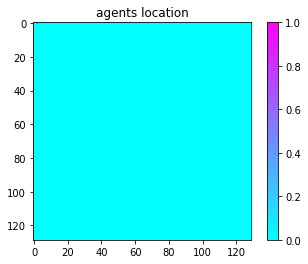

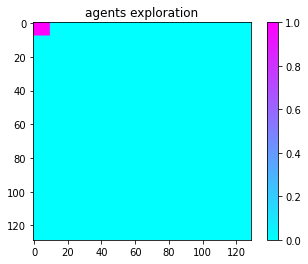

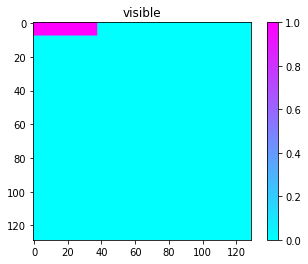

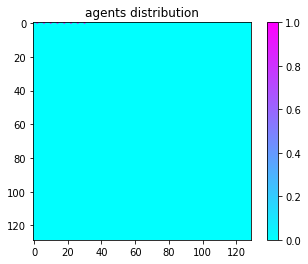

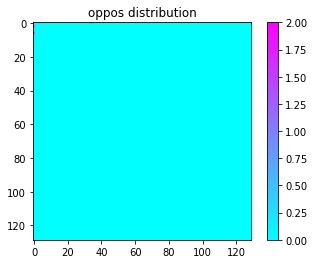

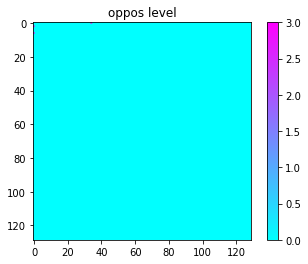

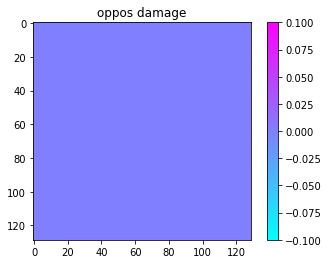

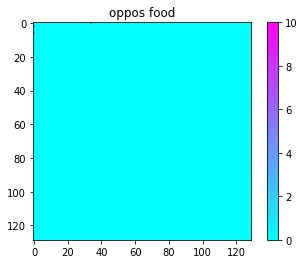

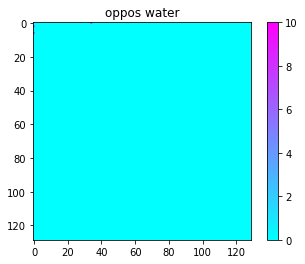

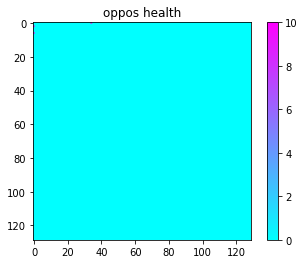

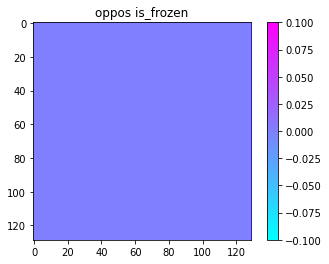

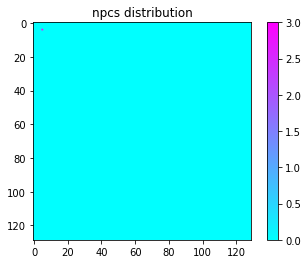

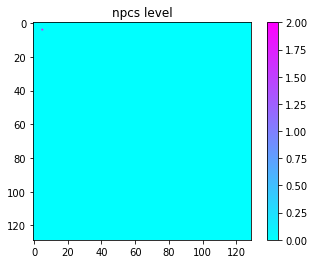

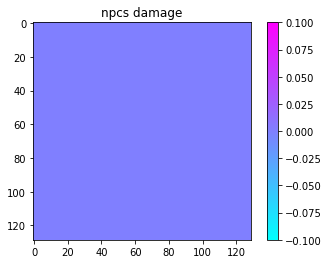

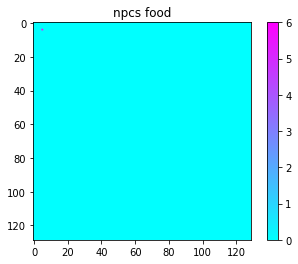

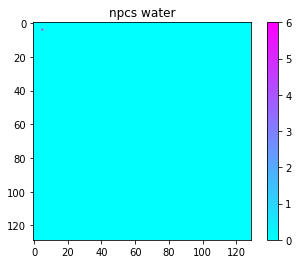

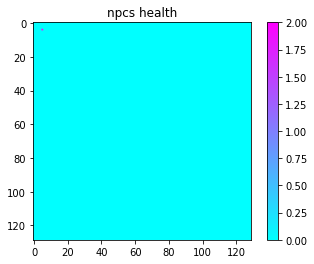

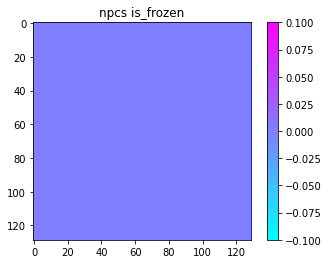

8


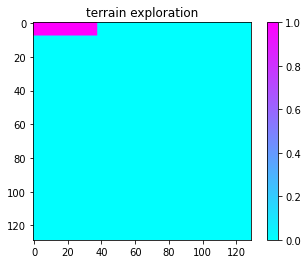

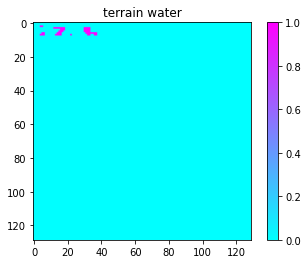

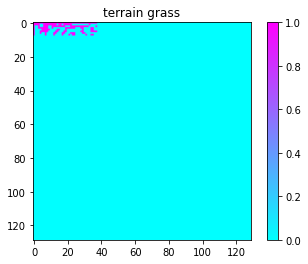

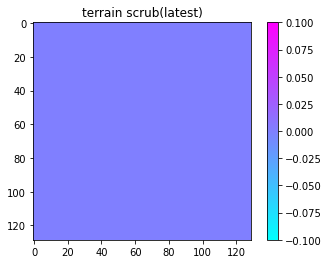

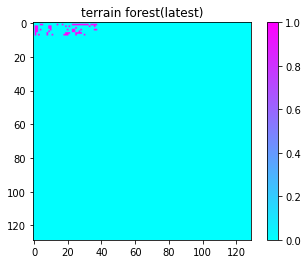

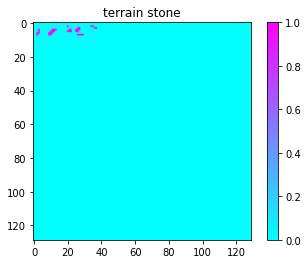

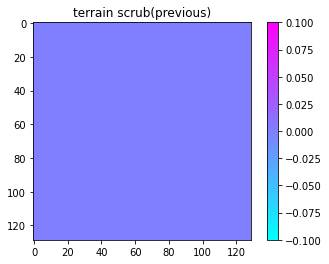

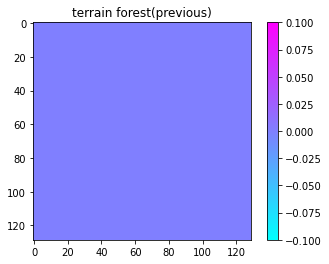

In [52]:
from ijcai2022nmmo import CompetitionConfig, scripted, TeamBasedEnv
import nmmo
import numpy as np
import matplotlib.pyplot as plt



Config = CompetitionConfig()
env = TeamBasedEnv(Config)
myteam = MyAwesomeTeam('myteam',Config)
myteam.reset()
obs = env.reset()
obs_team = obs[0]
new_obs = myteam.update_map(obs_team)
print(new_obs)
# print(new_obs[0].shape)
# print(new_obs[1].shape)

myteam.show_map(["agents","oppos","npcs"],[0,1],[0,1,2,3,4,5,6],agent_index=0,terrain_option=True,ter_attris=[0,1,2,3,4,5,6,7])

print( len(myteam.attack_objs) )  # attack_objs -> list[ np.ndarray(float32) ] 8个agent

In [36]:
myteam.global_map["terrain"][2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [ ]:
import gym
from gym import spaces
import numpy as np

observe = [spaces.Box(low=-1.0,high=1.0,shape=(20,20),dtype=np.float32)]*3
print(tuple(observe))


In [11]:
import ray 
import ray.rllib.agents.ppo as ppo
from ray.tune.logger import pretty_print
import tqdm
import json5
import ray.tune as tune 
import gym
import gym.spaces as spaces
import numpy as np
from ray.tune.registry import register_env

######### load config 
with open("config.json") as json_file:
    all_config = json5.load(json_file)
    
# all_config["lr"] = tune.grid_search([0.001,0.005])
# all_config["env"] = "MyTrainEnv"
    
print(pretty_print(all_config["algo_config"]))


batch_mode: truncate_episodes
create_env_on_driver: false
disable_env_checking: true
env_config:
  teams:
    CombatNoExploreTeam: 2
    CombatTeam: 3
    CombatTribridTeam: 2
    ForageNoExploreTeam: 2
    ForageTeam: 2
    MeanderTeam: 2
    RandomTeam: 2
evaluation_duration: 10
evaluation_duration_unit: episodes
evaluation_interval: 1000
exploration_config:
  type: StochasticSampling
explore: true
framework: torch
gamma: 0.99
lr: 0.0001
model:
  conv_activation: relu
  conv_filters:
  - - 80
    - - 129
      - 129
    - 1
  fcnet_activation: linear
  fcnet_hiddens: []
  post_fcnet_activation: relu
  post_fcnet_hiddens:
  - 100
  - 100
normalize_actions: false
num_envs_per_worker: 1
num_workers: 2
observation_filter: NoFilter
record_env: false
rollout_fragment_length: 200
train_batch_size: 400



In [13]:
##### register env    
def trainenv_creator(env_config):
    return MyTrainEnv(env_config)

register_env("MyTrainEnv",trainenv_creator)
# trainer = ppo.PPOTrainer(env="MyTrainEnv",config=all_config["algo_config"] )# config to pass to env class

all_config["env"] = "MyTrainEnv"
all_config["lr"] = tune.grid_search([0.001,0.0005])

tune.run('PPO',
         config=all_config["algo_config"],
         stop={"timesteps_total":40000}
        )

2022-06-22 12:24:11,062	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-06-22 12:24:15,783	INFO trainable.py:159 -- Trainable.setup took 19.441 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-06-22 12:24:15,790	WARNING util.py:65 -- Install gputil for GPU system monitoring.


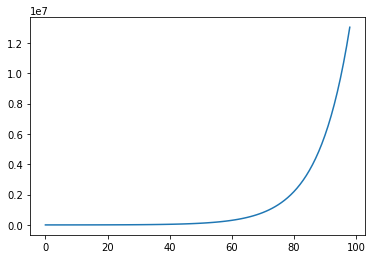

In [30]:
import matplotlib.pyplot as plt
exp = [0]
for i in range(2,99+1):
    increment = np.floor(i-1 + 300*(2**((i-1)/7.0)))/4.0
    exp += [exp[-1] + increment]
exp = np.floor(np.array(exp))
plt.plot(exp)
plt.show()